In [14]:
import skimage
import networkx as nx
import glob, os, sys
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from PIL import Image

In [24]:
#Libs needed for HC graph feats extraction
import math
import random
import collections
import functools
import operator as op
import warnings

from scipy.spatial import Voronoi
from scipy.spatial import cKDTree as KDTree
from skimage.filters.rank import entropy
from skimage.morphology import disk, dilation
from skimage.util import img_as_ubyte
from skimage.io import imread, imsave
from skimage.color import rgb2gray, rgb2lab, lab2rgb
from skimage.filters import sobel, gaussian
from skimage.restoration import denoise_bilateral
from skimage.transform import downscale_local_mean


In [2]:
path_mask = '/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/nuclei_segmentations/all/ZT76_39_A_1_1_pred-mask.png'
im_mask = np.array(Image.open(path_mask))[:,:,0]

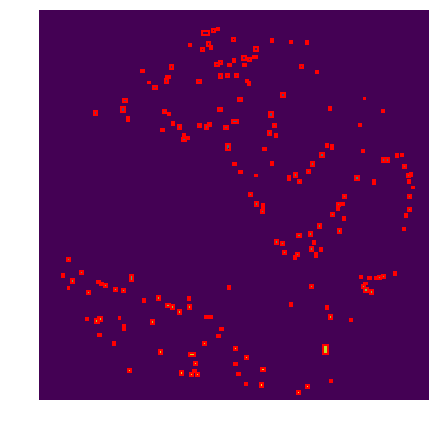

In [3]:
label_image = label(im_mask)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label_image)

num_regions = 0
coords_nucleus_center = []
for region in regionprops(label_image):
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    coords_nucleus_center.append(region.centroid)
    
    num_regions +=1
#ax.plot
ax.set_axis_off()
plt.tight_layout()
plt.show()



In [4]:
len(coords_nucleus_center)

182

In [5]:
r_probability = 0.3
alpha_exp = 0.20 #This should be drawn from an uniform distribution, 0.2 for the sake of inmediate reproducibility!

Y = distance.cdist(coords_nucleus_center, coords_nucleus_center, 'euclidean')

binary_adj_matrix =  np.power(Y,-alpha_exp) > r_probability
print(Y)
print(binary_adj_matrix)
#binary_adj_matrix[binary_adj_matrix == -np.inf] = 10
print(np.sum(binary_adj_matrix))

[[   0.           35.76730659  105.71650388 ... 2853.27780189
  2931.57309226 2960.62351655]
 [  35.76730659    0.           69.94925128 ... 2847.66189512
  2930.42244075 2958.45762148]
 [ 105.71650388   69.94925128    0.         ... 2838.09823883
  2929.58267335 2955.61789217]
 ...
 [2853.27780189 2847.66189512 2838.09823883 ...    0.
   371.3186448   302.20546264]
 [2931.57309226 2930.42244075 2929.58267335 ...  371.3186448
     0.           88.42320196]
 [2960.62351655 2958.45762148 2955.61789217 ...  302.20546264
    88.42320196    0.        ]]
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]
2862


/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


In [6]:
def graph_distances(im_path, coords_nucleus_center, r_probability, alpha_exp, plot_overlay=False):
    Y = distance.cdist(coords_nucleus_center, coords_nucleus_center, 'euclidean')
    binary_adj_matrix =  np.power(Y,-alpha_exp) > r_probability
    im_orig = np.array(Image.open(im_path))
    if plot_overlay:
        fig, ax = plt.subplots(figsize=(10, 6))
#        gca().set_axis_off()
#        subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#                    hspace = 0, wspace = 0)
#        margins(0,0)
        plt.margins(0.0)

#        gca().xaxis.set_major_locator(NullLocator())
#        gca().yaxis.set_major_locator(NullLocator())
        ax.imshow(im_orig)
        for i in range(len(coords_nucleus_center)):
            #Draw line if nuclei are \alpha close 
            for j in range(i):
                if binary_adj_matrix[i,j]:
                    ax.plot([coords_nucleus_center[i][1],coords_nucleus_center[j][1]],
                            [coords_nucleus_center[i][0],coords_nucleus_center[j][0]], 'g-',linewidth=1)
        ax.set_axis_off()
        plt.tight_layout()
        #plt.show()
        #plt.savefig('/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/nuclei_segmentations/graphs/'+im_path.split('/')[-1]+'_'+str(len(coords_nucleus_center))+'graph.png',
        #           bbox_inches='tight', pad_inches = 0, dpi=400)
    return Y, binary_adj_matrix

In [7]:
def coords_nucleus(mask_path, plot_mask = False):
    im_mask = np.array(Image.open(mask_path))[:,:,0]
    label_image = label(im_mask)
    if plot_mask:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(label_image)
    num_regions = 0
    coords_nucleus_center = []
    for region in regionprops(label_image):    
        coords_nucleus_center.append(region.centroid)
        # draw rectangle around segmented nuclei
        if plot_mask:
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        num_regions +=1
    #ax.plot
    if plot_mask:
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()
    return coords_nucleus_center

In [11]:
#Checking that the matrix is symmetric
print(np.allclose(binary_adj_matrix, binary_adj_matrix.T, atol=1e-8))

True


In [12]:
path_orig = '/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/all/ZT76_39_A_8_13.jpg'
path_mask = '/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/nuclei_segmentations/all/ZT76_39_A_8_13_pred-mask.png'

coords_nucleus_center = coords_nucleus(path_mask, plot_mask = False)
Y, binary_adj_matrix =  graph_distances(path_orig, coords_nucleus_center, r_probability, alpha_exp, plot_overlay=False)
print(Y.shape)

(305, 305)


/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
#Checking the average number of nuclei in the graph
tma_list = glob.glob('/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/all/*jpg')
masks_list  = glob.glob('/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/nuclei_segmentations/all/*')
masks_list.sort()
tma_list.sort()
print(tma_list[0])
print(masks_list[0])

/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/all/ZT111_4_A_1_12.jpg
/mnt/nas4/datasets/ToReadme/prostate_TMAs/dataverse_files/TMA_images/nuclei_segmentations/all/ZT111_4_A_1_12_pred-mask.png


In [ ]:
coords_lenghts = []
for mnum in range(len(masks_list)):
    coords_nucleus_center = coords_nucleus(masks_list[mnum], plot_mask = False)
    Y, binary_adj_matrix =  graph_distances(tma_list[mnum], coords_nucleus_center, r_probability, alpha_exp, plot_overlay=True)
    coords_lenghts.append(len(coords_nucleus_center))
    print(coords_lenghts[-1])

/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


279
203
305
200
331
320
300
393
232
273
249


In [320]:
print(np.average(coords_lenghts))
print(np.std(coords_lenghts))
print(np.var(coords_lenghts))
print(np.max(coords_lenghts))
print(np.min(coords_lenghts))

225.55191873589166
62.25456651221011
3875.631051623193
405
33


In [302]:
len(coords_nucleus_center)

305

In [7]:
max_ind = (0,0)
max_dist = 0
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        if max_dist < Y[i,j]:
            max_dist = Y[i,j]
            max_ind = i,j
print(max_dist, max_ind)                   

2968.809066082061 (6, 171)


In [13]:
Y = distance.cdist(coords_nucleus_center, coords_nucleus_center, 'euclidean')
d_max = np.unravel_index([np.argmax(Y)],Y.shape)
d_min = np.unravel_index([np.argmin(Y)],Y.shape)
print(d_max,d_min)

# draw diagonal line from (70, 90) to (90, 200)
#ax.plot([coords_nucleus_center[max_ind[0]][1],coords_nucleus_center[max_ind[1]][1]],
#        [coords_nucleus_center[max_ind[0]][0],coords_nucleus_center[max_ind[1]][0]], 'k-')


(array([3]), array([304])) (array([0]), array([0]))


In [16]:
binary_adj_matrix.shape

(305, 305)

In [14]:
Y

array([[   0.        ,  128.09929131,   85.78708439, ..., 2963.0885335 ,
        2966.31726654, 2985.84595488],
       [ 128.09929131,    0.        ,   46.76608654, ..., 2937.69196172,
        2956.70864517, 2973.7275709 ],
       [  85.78708439,   46.76608654,    0.        , ..., 2929.86142034,
        2943.18950436, 2961.09867136],
       ...,
       [2963.0885335 , 2937.69196172, 2929.86142034, ...,    0.        ,
         367.9429456 ,  312.08867263],
       [2966.31726654, 2956.70864517, 2943.18950436, ...,  367.9429456 ,
           0.        ,   61.20497079],
       [2985.84595488, 2973.7275709 , 2961.09867136, ...,  312.08867263,
          61.20497079,    0.        ]])

In [50]:
G = nx.from_numpy_matrix(Y)

In [47]:
nx.voronoi_cells(G,center_nodes=G.nodes)

{0: {0},
 1: {1},
 2: {2},
 3: {3},
 4: {4},
 5: {5},
 6: {6},
 7: {7},
 8: {8},
 9: {9},
 10: {10},
 11: {11},
 12: {12},
 13: {13},
 14: {14},
 15: {15},
 16: {16},
 17: {17},
 18: {18},
 19: {19},
 20: {20},
 21: {21},
 22: {22},
 23: {23},
 24: {24},
 25: {25},
 26: {26},
 27: {27},
 28: {28},
 29: {29},
 30: {30},
 31: {31},
 32: {32},
 33: {33},
 34: {34},
 35: {35},
 36: {36},
 37: {37},
 38: {38},
 39: {39},
 40: {40},
 41: {41},
 42: {42},
 43: {43},
 44: {44},
 45: {45},
 46: {46},
 47: {47},
 48: {48},
 49: {49},
 50: {50},
 51: {51},
 52: {52},
 53: {53},
 54: {54},
 55: {55},
 56: {56},
 57: {57},
 58: {58},
 59: {59},
 60: {60},
 61: {61},
 62: {62},
 63: {63},
 64: {64},
 65: {65},
 66: {66},
 67: {67},
 68: {68},
 69: {69},
 70: {70},
 71: {71},
 72: {72},
 73: {73},
 74: {74},
 75: {75},
 76: {76},
 77: {77},
 78: {78},
 79: {79},
 80: {80},
 81: {81},
 82: {82},
 83: {83},
 84: {84},
 85: {85},
 86: {86},
 87: {87},
 88: {88},
 89: {89},
 90: {90},
 91: {91},
 92: {92

In [25]:
#The disorder of the area is defined as DA = 1/(1+(std^{A}/N^{A})) where A 

In [26]:
coords_nucleus_center

[(90.26014760147602, 1761.0110701107012),
 (99.23987034035656, 1633.226904376013),
 (112.35179153094462, 1678.1172638436483),
 (123.171974522293, 915.8012738853503),
 (132.79738562091504, 1737.6753812636166),
 (148.5032362459547, 1310.8478964401295),
 (149.1970217640321, 1003.758304696449),
 (148.81512605042016, 1262.997198879552),
 (191.56515580736544, 1022.3229461756374),
 (215.43434343434345, 1304.5732323232323),
 (219.8390092879257, 1189.6687306501549),
 (242.54102920723227, 793.2294853963839),
 (254.43595505617978, 1193.7123595505618),
 (260.7582292849035, 2103.1816118047673),
 (274.5860349127182, 953.0523690773067),
 (290.086230876217, 659.7176634214186),
 (324.47112117780296, 1887.7214043035108),
 (338.6272040302267, 538.9823677581863),
 (376.20109439124485, 465.43502051983586),
 (405.3814955640051, 1934.8326996197718),
 (436.8779342723005, 1663.556338028169),
 (450.5112285336856, 834.7384412153236),
 (460.3127147766323, 590.4398625429553),
 (488.7308533916849, 821.6126914660831

In [33]:
np.min(coords_nucleus_center,axis=0)

array([90.2601476 , 61.36774194])

# Voronoi diagram of the images

In [25]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                    [2, 0], [2, 1], [2, 2]])

In [26]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [40]:
vor = Voronoi(coords_nucleus_center,furthest_site=False)


In [41]:
vor.regions

[[16, 12, 14, 13, 15],
 [53, 46, 47, 52],
 [64, 19, 63],
 [71, 69, 68, 67, 70],
 [70, 17, 18, 67],
 [68, 61, 60, 7, 8, 18, 67],
 [69, 19, 63, 62, 59, 61, 68],
 [71, 20, 66, 64, 19, 69],
 [71, 20, 0, 17, 70],
 [73, 1, 4, 3, -1, 72],
 [78, -1, 77],
 [-1, 30, 31, 79],
 [83, 80, 26, 27, 81],
 [82, 29, 6, 27, 81],
 [87, 85, 84, 86],
 [85, 33, 29, 6, 25, 84],
 [87, 30, 31, 32, 33, 85],
 [103, 24, 25, 6, 27, 26, 28, 102],
 [115, 42, 44, 43, 41, 40, 114],
 [124, 122, 121, 50, 54, 123],
 [126, 52, 53, 54, 50, 51, 125],
 [128, 10, 12, 14, -1, 127],
 [130, 10, 12, 16, 56, 129],
 [131, 128, 10, 130],
 [132, 125, 126, 127, 128, 131],
 [137, 135, 134, 136],
 [135, 62, 59, 93, 92, 57, 56, 16, 15, 134],
 [136, 13, 15, 134],
 [137, 65, 66, 64, 63, 62, 135],
 [137, 65, -1, 14, 13, 136],
 [141, 139, 138, 140],
 [141, 22, 21, 0, 20, 66, 65, -1, 140],
 [143, 21, 0, 17, 18, 8, 142],
 [144, 22, 21, 143],
 [149, 147, 148],
 [148, 75, 5, 1, 4, 147],
 [152, 35, 76, 150],
 [154, -1, 79, 153],
 [155, 32, 31, 79, 

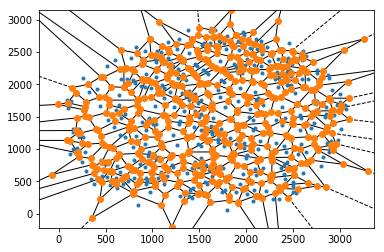

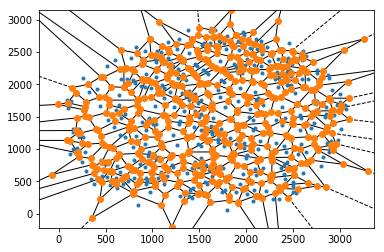

In [42]:
voronoi_plot_2d(vor)

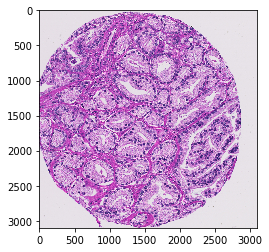

In [31]:
plt.imshow(Image.open(path_orig))